# A1: Data Curation

The purpose of this notebook is to showcase a dataset, whilst adhering to principles of reproducible research. The reference articles used for this purpose are 
  1. [Assessing Reproducability](https://www.practicereproducibleresearch.org/core-chapters/2-assessment.html)
  2. [The Basic Reproducible Workflow Template](https://www.practicereproducibleresearch.org/core-chapters/3-basic.html)
  
### Table of Contents

1. [Step 1: Data Acquisition](#s1)  
  a. [Getting Legacy PageCounts Data](#s1_1)  
  b. [Getting PageViews Data](#s1_2)
2. [Step 2: Data Processing](#s2)
3. [Step 3: Analysis](#s3)

In [1]:
import os
import shutil
from collections import defaultdict
from functools import reduce

import json
import requests

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

<a id="s1"></a>

## Step 1 - Data Acquisition

We use two Wikimedia API endpoints:
  1. [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts)
  2. [Pageviews API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)

In [2]:
ENDPOINT_ROOT = "https://wikimedia.org/api/rest_v1/metrics/"
ENDPOINT_LEGACY = ENDPOINT_ROOT + 'legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
ENDPOINT_PAGEVIEW = ENDPOINT_ROOT + 'pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
COMMON_PARAMS = {
    "project" : "en.wikipedia.org",
    "granularity" : "monthly",
}

OUTPUT_JSON_DIR = "json"
OUTPUT_CSV_DIR = "csv"

HEADERS = {
    'User-Agent': 'https://github.com/havanagrawal',
    'From': 'agrawh@uw.edu'
}

In [4]:
# Delete the directory if it already exists, and then recreate it
if os.path.exists(OUTPUT_JSON_DIR):
    shutil.rmtree(OUTPUT_JSON_DIR)
    
if os.path.exists(OUTPUT_CSV_DIR):
    shutil.rmtree(OUTPUT_CSV_DIR)
    
os.mkdir(OUTPUT_JSON_DIR)
os.mkdir(OUTPUT_CSV_DIR)

In [5]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=HEADERS)
    response = call.json()
    
    return response

In [6]:
def get_output_file_path(api_type, accesstype, start, end):
    filename = "{api_type}_{accesstype}_{start}-{end}.json".format(api_type=api_type, accesstype=accesstype, start=start, end=end)
    return os.path.join(OUTPUT_JSON_DIR, filename)

In [7]:
def write_to_json(data, filename):
    data_string = json.dumps(data, indent=2)
    with open(filename, "w") as f:
        f.write(data_string)
        
def read_from_json(filename):
    data = {}
    with open(filename, "r") as f:
        data = json.loads(f.read())
    
    return data

<a id="s1_1"></a>

### Getting Legacy PageCounts Data

In [8]:
def get_legacy_page_count_data(access_site, start, end):
    params = {
        "access-site" : access_site,
        "start" : start,
        "end" : end
    }
    params.update(COMMON_PARAMS)
    data = api_call(ENDPOINT_LEGACY, params)
    output_filepath = get_output_file_path("pagecounts", access_site, start, end)
    
    write_to_json(data, output_filepath)
    
    return output_filepath

In [9]:
start, end = "2007120100", "2016080100"
pagecount_desktop_file = get_legacy_page_count_data('desktop-site', start, end)
pagecount_mobile_file = get_legacy_page_count_data('mobile-site', start, end)

<a id="s1_2"></a>

### Getting PageViews Data

In [10]:
def get_page_view_data(access_site, start, end):
    params = {
        "access" : access_site,
        "start" : start,
        "end" : end,
        "agent": "user"
    }
    params.update(COMMON_PARAMS)
    data = api_call(ENDPOINT_PAGEVIEW, params)
    output_filepath = get_output_file_path("pageviews", access_site, start, end)
    
    write_to_json(data, output_filepath)
    
    return output_filepath

In [11]:
start, end = "2015070100", "2018100100"
pageview_desktop_file = get_page_view_data("desktop", start, end)
pageview_mobile_app_file = get_page_view_data("mobile-app", start, end)
pageview_mobile_site_file = get_page_view_data("mobile-web", start, end)

In [12]:
# Should have 5 files
output_files = os.listdir(OUTPUT_JSON_DIR)
assert len(output_files) == 5
output_files

['pageviews_mobile-app_2015070100-2018100100.json',
 'pagecounts_mobile-site_2007120100-2016080100.json',
 'pageviews_desktop_2015070100-2018100100.json',
 'pagecounts_desktop-site_2007120100-2016080100.json',
 'pageviews_mobile-web_2015070100-2018100100.json']

<a id="s2"></a>

## Step 2 - Data Processing

In [13]:
def year(ts):
    return int(ts[:4])

def month(ts):
    return int(ts[4:6])

def yyyymm(ts):
    return str(year(ts)) + str(month(ts)).rjust(2, "0")

We read the generated JSON files from the previous step

In [14]:
pageviews_mobile_app = read_from_json('json/pageviews_mobile-app_2015070100-2018100100.json')
pageviews_mobile_site = read_from_json('json/pageviews_mobile-web_2015070100-2018100100.json')
pageviews_desktop_site = read_from_json("json/pageviews_desktop_2015070100-2018100100.json")

pagecount_mobile = read_from_json("json/pagecounts_mobile-site_2007120100-2016080100.json")
pagecount_desktop_site = read_from_json("json/pagecounts_desktop-site_2007120100-2016080100.json")

In [15]:
pageviews_mobile_views = defaultdict(int)
pageviews_desktop_views = defaultdict(int)

pagecounts_mobile_views = defaultdict(int)
pagecounts_desktop_views = defaultdict(int)

In [16]:
def fill_dict(src_data, dest_dict):
    for item in src_data['items']:
        key = yyyymm(item['timestamp'])
        if 'views' in item:
            dest_dict[key] += item['views']
        else:
            dest_dict[key] += item['count']
            
def make_df(d, value_key):
    return pd.DataFrame({'yyyymm': list(d.keys()), value_key: list(d.values())})

Combine the results from the mobile site and mobile web app for the page view data

In [17]:
fill_dict(pageviews_mobile_app, pageviews_mobile_views)
fill_dict(pageviews_mobile_site, pageviews_mobile_views)

The others go into their respective independent counting dictionaries

In [18]:
fill_dict(pageviews_desktop_site, pageviews_desktop_views)

fill_dict(pagecount_desktop_site, pagecounts_desktop_views)
fill_dict(pagecount_mobile, pagecounts_mobile_views)

Since the desired output is a CSV file, the most convenient way to do so would be to convert the JSON into DataFrames, process and merge them, and then write the DataFrame into CSV

In [19]:
pv_mobile_df = make_df(pageviews_mobile_views, 'pageview_mobile_views')
pc_mobile_df = make_df(pagecounts_mobile_views, 'pagecount_mobile_views')

pv_desktop_df = make_df(pageviews_desktop_views, 'pageview_desktop_views')
pc_desktop_df = make_df(pagecounts_desktop_views, 'pagecount_desktop_views')

We apply a `reduce` function that merges all of the data frames into a single one, using the year-month pair as key.

In [20]:
def merger(d1, d2):
    return d1.merge(d2, on='yyyymm', how='outer')

df = reduce(merger, [pv_mobile_df, pc_mobile_df, pv_desktop_df, pc_desktop_df])
    
df.fillna(0, inplace=True)

The key to join on is the year and month, i.e. we throw away

Add/remove columns as per the required schema

In [21]:
df['pagecount_all_views'] = df['pagecount_mobile_views'] + df['pagecount_desktop_views']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pageview_desktop_views']
df['year'] = df.yyyymm.apply(str).apply(year)
df['month'] = df.yyyymm.apply(str).apply(month)

In [22]:
min_date, max_date = df.yyyymm.min(), df.yyyymm.max()
min_date, max_date

('200712', '201809')

In [23]:
df.drop('yyyymm', axis=1, inplace=True)

And finally write it out into a single CSV file

In [24]:
output_csv_filename = "en-wikipedia_traffic_{from_date}-{to_date}.csv".format(from_date=min_date, to_date=max_date)
output_csv_filepath = os.path.join(OUTPUT_CSV_DIR, output_csv_filename)
df.to_csv(output_csv_filepath, index=False)

<a id="s3"></a>

## Step 3: Analysis

In [25]:
df = pd.read_csv(output_csv_filepath)

In order to plot time series data, we sort by the year and month

In [26]:
df.sort_values(by=['year', 'month'], inplace=True)
df["yyyymm"] = df.apply(lambda r: str(int(r.year)) + str(int(r.month)).rjust(2, "0"), axis=1)

In [27]:
df = df.replace(to_replace=0, value=pd.np.nan)

In [28]:
df['date'] = df.apply(lambda r: pd.datetime(r.year, r.month, 1), axis=1)

In [29]:
df.columns

Index(['pageview_mobile_views', 'pagecount_mobile_views',
       'pageview_desktop_views', 'pagecount_desktop_views',
       'pagecount_all_views', 'pageview_all_views', 'year', 'month', 'yyyymm',
       'date'],
      dtype='object')

In [30]:
ymax = df[[f for f in df.columns if "views" in f]].max().max()

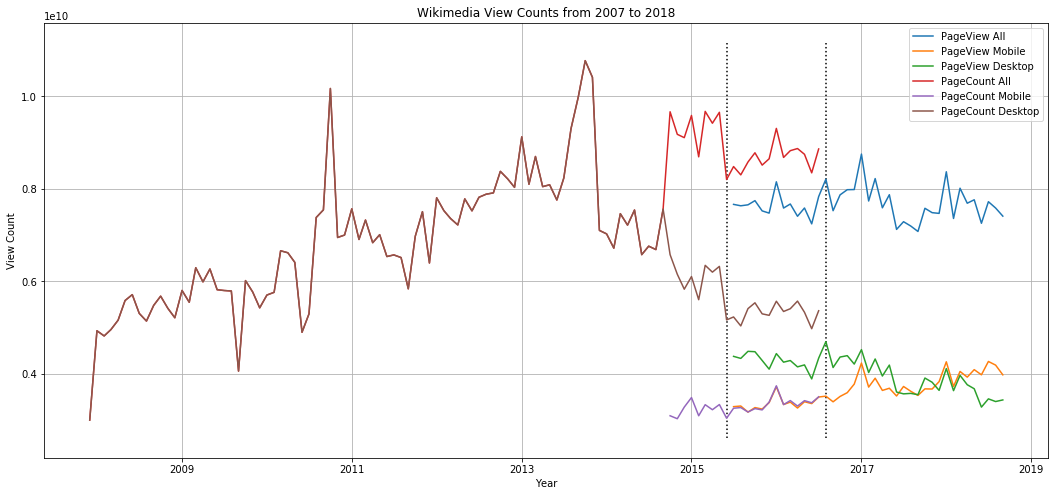

In [31]:
plt.figure(figsize=(18, 8))

plt.plot(df.date, df.pageview_all_views)
plt.plot(df.date, df.pageview_mobile_views)
plt.plot(df.date, df.pageview_desktop_views)

plt.plot(df.date, df.pagecount_all_views)
plt.plot(df.date, df.pagecount_mobile_views)
plt.plot(df.date, df.pagecount_desktop_views)

ymin, ymax = plt.ylim()

plt.legend(["PageView All", "PageView Mobile", "PageView Desktop", "PageCount All", "PageCount Mobile", "PageCount Desktop"])

plt.vlines([df[df.pagecount_all_views.isna()].date.min()], ymin=ymin, ymax=ymax, linestyles='dotted')
plt.vlines([df[df.pageview_all_views.isna()].date.max()], ymin=ymin, ymax=ymax, linestyles='dotted')

plt.xlabel("Year")
plt.ylabel("View Count")

plt.title("Wikimedia View Counts from 2007 to 2018")
plt.grid()

The dotted lines enclose the region of overlap